# Bilateral International Migration prediction using Deep Learning #


Ludwig-Maximilians-Universität M.Economics Machine Learning Applications - WS2020/21 Term Paper

Code by: Yunting LIU,  15.03.2021

## Research question ##

My research subject is to predict bilateral international migration flow. 

I take a subset of data used in "An LSTM approach to Predict Migration based on Google Trends" by Nicolas Golenvaux et al. 2020 (XXX [2, 3]) and extend the existing work by incorporating TabNet model (XXX [2, 3]) and by extending on cross-model result intepretation.  


# Initialising

In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.metrics import Metric

import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score 
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from typing import Tuple
from xgboost import XGBRegressor

import pandas as pd
import numpy as np
import xarray

import os
import wget
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import SymLogNorm
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import pandas_profiling

/Users/jacqueline/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jacqueline/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
#import keras.backend as kb

from tensorflow import keras

import tensorflow.keras.backend as kb

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout


# from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor


In [3]:
# Set a random seed to ensure result reproducibility
random_seed = 123

# tensorflow.random.set_seed(random_seed)

# Data

The main data set is made available from [1] and downloaded on the following website : [https://www.sciencedirect.com/science/article/pii/S0304387819304900](https://www.sciencedirect.com/science/article/pii/S0304387819304900)

For convenience i have downloaded a copy of this in my local directory.

## Data import 

In [4]:
os.getcwd()

'/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper'

In [5]:
data_in = pd.read_stata('/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/migration_gti_lstm/replicate/data/replication_bilateral.dta')

In [6]:
# skip data columns with "GTI" - these relate to internet search keywords which I wish to exclude for this first modelling
# further skip all the log transformation columns
exclude_log_cols = ['o_log_pop', 'd_log_pop', 'o_log_gdp', 'd_log_gdp', 'log_mig_stock']
cols = [c for c in data_in.columns if (c.lower()[:3] != 'gti' and c.lower() not in exclude_log_cols)]

data=data_in[cols].copy()

data

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776


In [7]:
data.shape

(23947, 29)

## Data Exploration 

In [9]:
# take a look into a random subset of data
# pandas_profiling.ProfileReport(data.sample(n = 5000, random_state = 123))

TypeError: concat() got an unexpected keyword argument 'join_axes'

# Model Training 

## Data preparation for modelling, split and feature selection 

In [10]:
data_modelling = data

# use log(migration) as model target; this forces models to always predict a positive value for migration
target = 'fwd_log_mig' 

unused_feat = ['Set', 'iso3n_o', 'iso3n_d', 'source_country', 'iso3n_oXyear', 'iso3n_dXyear', 'tot_mig', 'fwd_tot_mig', 'log_mig']

features = [ col for col in data_modelling.columns if col not in unused_feat+[target]] 
col_used = [ col for col in data_modelling.columns if col not in unused_feat] 

In [11]:
data_modelling = data_modelling[col_used].copy()

np.random.seed(seed=random_seed)

if "Set" not in data_modelling.columns:
    data_modelling["Set"] = np.random.choice(["train", "valid", "test"], p =[.6, .2, .2], size=(data_modelling.shape[0],))

train_indices = data_modelling[data_modelling.Set=="train"].index
valid_indices = data_modelling[data_modelling.Set=="valid"].index
test_indices = data_modelling[data_modelling.Set=="test"].index

In [12]:
# Simple feature pre-processing

nunique = data_modelling.nunique()
types = data_modelling.dtypes

categorical_columns = []
categorical_dims =  {}

for col in data_modelling.columns[data_modelling.dtypes == object]:
    print(col, data_modelling[col].nunique())
    l_enc = LabelEncoder()
    data_modelling[col] = data_modelling[col].fillna("VV_likely")
    data_modelling[col] = l_enc.fit_transform(data_modelling[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

numerical_columns = []
numerical_dims =  {}    
    
for col in data_modelling.columns[data_modelling.dtypes == 'float64']:
    data_modelling.fillna(data_modelling.loc[train_indices, col].mean(), inplace=True)
#    sc = StandardScaler()
#    train[col] = sc.fit_transform(train[col].values)
#    train[col] = np.squeeze(sc.fit_transform(train[col].values.reshape(-1, 1)))
#    numerical_columns.append(col)
#    numerical_dims[col] = len(l_enc.classes_)
    

iso3_o 101
iso3_d 35
Set 3


In [13]:
data_modelling

,pair_id,year,iso3_o,iso3_d,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,Set
0,171,2004,0,0,5.961005,12.600000,26.647324,4.0,0.0,35.272288,16.036684,3,0,9.557068,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,2
1,171,2005,0,0,5.590987,10.600000,26.321699,2.0,0.0,57.328994,17.720583,1,0,9.557068,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,1
2,171,2006,0,0,5.164786,10.100000,26.007032,2.0,0.0,80.818826,20.927202,1,0,9.557068,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,1
3,171,2007,0,0,5.170484,8.500000,25.702198,2.0,0.0,102.721528,25.946633,3,0,9.557068,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,1
4,171,2008,0,0,5.087596,7.800000,25.410353,2.0,0.0,117.221183,28.112623,1,1,9.557068,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,2010,100,32,3.433987,5.500000,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.000000,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,0
23943,7021,2011,100,32,3.295837,5.400000,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.000000,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,1
23944,7021,2012,100,32,2.772589,5.300000,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.000000,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,1
23945,7021,2013,100,32,3.688879,5.400000,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.000000,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,2


In [14]:
# Split into train, validation and test set
X_train = data_modelling[features].values[train_indices]
y_train = data_modelling[target].values[train_indices].reshape(-1, 1)

X_valid = data_modelling[features].values[valid_indices]
y_valid = data_modelling[target].values[valid_indices].reshape(-1, 1)

X_test = data_modelling[features].values[test_indices]
y_test = data_modelling[target].values[test_indices].reshape(-1, 1)

## Defining CPC and R2 as custom metric, defining CPC as loss function 

In [15]:
# Define Common Part of Commuters (CPC) and R_squared as custom metrics

class CPC(Metric):
    def __init__(self):
        self._name = "cpc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        cpc = 2 * np.sum(np.minimum(y_true, y_score)) / (np.sum(y_true) + np.sum(y_score))
        return cpc

# Coefficient of determination r^2

class r_squared(Metric):
    def __init__(self):
        self._name = "r_squared"
        self._maximize = True

    def __call__(self, y_true, y_score):
        SS_res = np.sum(np.square(y_true - y_score))
        SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
        r_squared = (1 - SS_res / (SS_tot))          
        return r_squared

custom_metrics = ['mae', 'mse', 'rmse', r_squared, CPC]

In [16]:
# Again for Keras models
# Common Part of Commuters
def cpc_keras(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

# Coefficient of determination r^2
def r_squared_keras(y_true, y_pred):
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    r_squared = (1 - SS_res / (SS_tot + kb.epsilon()))
    return r_squared

rmse_keras = keras.metrics.RootMeanSquaredError()

custom_metrics_keras = ['mae', 'mse', rmse_keras, r_squared_keras, cpc_keras] # to be passed to model.compile(), metrics parameter


In [17]:
def cpc_loss(y_pred, y_true):
    cpc = 2 * torch.sum(torch.minimum(y_true, y_pred)) / (torch.sum(y_true) + torch.sum(y_pred))
    return 1-cpc

In [18]:
def cpc_loss_xgb(y_pred, y_true):
    print(y_pred)
    print(y_pred.shape)
    print(y_true)
    print(y_true.shape)
    cpc = 2 * sum(np.minimum(y_true, y_pred)) / (sum(y_true) + sum(y_pred))    
    return cpc

In [19]:
def cpc_loss_keras(y_true, y_pred):
    return 1.0 - cpc_keras(y_true, y_pred)

## Training Models - 1. TabNet Model 

In [20]:
# Define categorical features for categorical embeddings
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [34]:
modelTabnet = TabNetRegressor(cat_dims=cat_dims, cat_idxs=cat_idxs, seed = random_seed, device_name='cpu')

modelTabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'valid'],
    eval_metric= ['mae', 'mse', 'rmse', r_squared, CPC],
    loss_fn = cpc_loss,
    max_epochs=1000,
    patience=50,
    batch_size=1280, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

Device used : cpu
epoch 0  | loss: 0.58689 | train_mae: 4.770020008087158| train_mse: 270.9527282714844| train_rmse: 16.46063995361328| train_r_squared: -39.54193| train_cpc: 0.31982 | valid_mae: 5.27338981628418| valid_mse: 376.8651123046875| valid_rmse: 19.413009643554688| valid_r_squared: -53.40931| valid_cpc: 0.2166  |  0:00:01s
epoch 1  | loss: 0.30697 | train_mae: 3.559760093688965| train_mse: 34.24311828613281| train_rmse: 5.851759910583496| train_r_squared: -4.12371| train_cpc: 0.6111  | valid_mae: 3.6079800128936768| valid_mse: 37.923919677734375| valid_rmse: 6.158239841461182| valid_r_squared: -4.47521| valid_cpc: 0.61079 |  0:00:02s
epoch 2  | loss: 0.27559 | train_mae: 2.3957300186157227| train_mse: 9.330840110778809| train_rmse: 3.054640054702759| train_r_squared: -0.39615| train_cpc: 0.67693 | valid_mae: 2.400330066680908| valid_mse: 9.896510124206543| valid_rmse: 3.1458699703216553| valid_r_squared: -0.42879| valid_cpc: 0.67877 |  0:00:04s
epoch 3  | loss: 0.2616  | trai

epoch 26 | loss: 0.16338 | train_mae: 2.13346004486084| train_mse: 6.995530128479004| train_rmse: 2.6449100971221924| train_r_squared: -0.04672| train_cpc: 0.70063 | valid_mae: 2.1357600688934326| valid_mse: 7.061520099639893| valid_rmse: 2.6573500633239746| valid_r_squared: -0.0195 | valid_cpc: 0.70484 |  0:00:41s
epoch 27 | loss: 0.15902 | train_mae: 2.025559902191162| train_mse: 6.289330005645752| train_rmse: 2.507849931716919| train_r_squared: 0.05894 | train_cpc: 0.71681 | valid_mae: 2.0232300758361816| valid_mse: 6.278600215911865| valid_rmse: 2.5057098865509033| valid_r_squared: 0.09354 | valid_cpc: 0.72142 |  0:00:43s
epoch 28 | loss: 0.15642 | train_mae: 2.0314700603485107| train_mse: 6.276430130004883| train_rmse: 2.505280017852783| train_r_squared: 0.06087 | train_cpc: 0.71585 | valid_mae: 2.0288798809051514| valid_mse: 6.288579940795898| valid_rmse: 2.507699966430664| valid_r_squared: 0.0921  | valid_cpc: 0.72044 |  0:00:44s
epoch 29 | loss: 0.15649 | train_mae: 1.948250055

epoch 52 | loss: 0.14208 | train_mae: 1.1580400466918945| train_mse: 2.3384900093078613| train_rmse: 1.5292099714279175| train_r_squared: 0.6501  | train_cpc: 0.83174 | valid_mae: 1.2084800004959106| valid_mse: 2.5122599601745605| valid_rmse: 1.585010051727295| valid_r_squared: 0.6373  | valid_cpc: 0.82739 |  0:01:22s
epoch 53 | loss: 0.14186 | train_mae: 1.1351399421691895| train_mse: 2.3064498901367188| train_rmse: 1.5187000036239624| train_r_squared: 0.65489 | train_cpc: 0.83214 | valid_mae: 1.1825599670410156| valid_mse: 2.4727399349212646| valid_rmse: 1.5724899768829346| valid_r_squared: 0.643   | valid_cpc: 0.82796 |  0:01:24s
epoch 54 | loss: 0.1392  | train_mae: 1.2904599905014038| train_mse: 2.811769962310791| train_rmse: 1.6768300533294678| train_r_squared: 0.57928 | train_cpc: 0.81979 | valid_mae: 1.3298900127410889| valid_mse: 2.9526000022888184| valid_rmse: 1.718309998512268| valid_r_squared: 0.57372 | valid_cpc: 0.81718 |  0:01:25s
epoch 55 | loss: 0.13911 | train_mae: 1.

epoch 78 | loss: 0.12744 | train_mae: 1.1011899709701538| train_mse: 2.1340699195861816| train_rmse: 1.4608500003814697| train_r_squared: 0.68068 | train_cpc: 0.83873 | valid_mae: 1.1402499675750732| valid_mse: 2.3007800579071045| valid_rmse: 1.5168299674987793| valid_r_squared: 0.66783 | valid_cpc: 0.83588 |  0:02:03s
epoch 79 | loss: 0.12586 | train_mae: 1.1873500347137451| train_mse: 2.333899974822998| train_rmse: 1.5277099609375| train_r_squared: 0.65079 | train_cpc: 0.83082 | valid_mae: 1.2269599437713623| valid_mse: 2.4956400394439697| valid_rmse: 1.579759955406189| valid_r_squared: 0.6397  | valid_cpc: 0.828   |  0:02:04s
epoch 80 | loss: 0.12642 | train_mae: 1.302459955215454| train_mse: 2.7117300033569336| train_rmse: 1.6467299461364746| train_r_squared: 0.59425 | train_cpc: 0.82027 | valid_mae: 1.3348100185394287| valid_mse: 2.8539600372314453| valid_rmse: 1.689370036125183| valid_r_squared: 0.58796 | valid_cpc: 0.8187  |  0:02:06s
epoch 81 | loss: 0.12753 | train_mae: 1.4368

In [ ]:
# batch_size 1280: best_valid_cpc = 0.62423
# 2560: best_valid_cpc = 0.63493

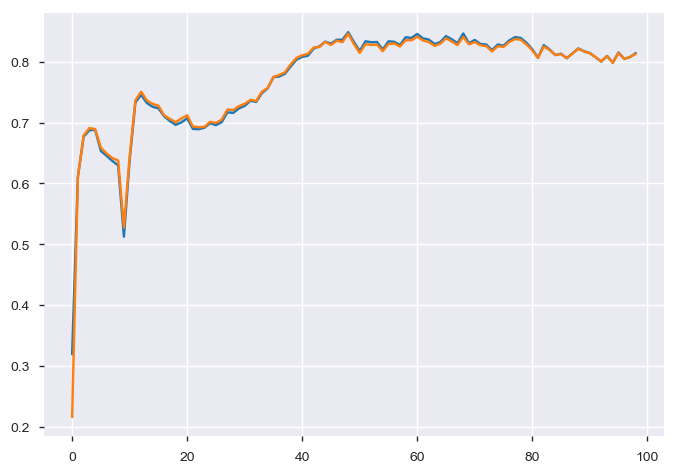

In [35]:
# plot losses
# plt.plot(modelTabnet.history['loss'])

# Plot development of cpc

plt.plot(modelTabnet.history['train_cpc'])
plt.plot(modelTabnet.history['valid_cpc'])

## Training Models - 2. Artificial Neural Network (ANN)  

In [43]:
# define ANN model
# @l : loss function to build model
# @size_hidden_layer : the size of all the hidden layers of the ANN 
# @dropout : the dropout of the model
# @n_layer : the number of hidden layers of the model
# @returns : the defined model
def defineANN(n_features = 20,l='mse',size_hidden_layer=20,dropout=0.15,n_layer=2):  #l=cpc_loss_keras
  model = Sequential()
  if dropout > 0.0:
    model.add(Dropout(dropout,input_shape=(n_features,)))
  for i in range(n_layer):
    model.add(Dense(size_hidden_layer, activation='relu', input_shape=(n_features,)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss=l, metrics = custom_metrics_keras)
  return model

In [44]:
modelAnn = defineANN()
historyAnn = modelAnn.fit(X_train, y_train, epochs=2000, batch_size=128, verbose=1, validation_data=(X_valid, y_valid))


Epoch 1/2000
113/113 [==============================] - 1s 3ms/step - loss: 77650629.9474 - mae: 657.1755 - mse: 77650629.9474 - root_mean_squared_error: 8317.9054 - r_squared_keras: -10930549.3169 - cpc_keras: 1.0398 - val_loss: 403467.4688 - val_mae: 135.9041 - val_mse: 403467.4688 - val_root_mean_squared_error: 635.1909 - val_r_squared_keras: -52923.2930 - val_cpc_keras: 3.5767
Epoch 2/2000
113/113 [==============================] - 0s 1ms/step - loss: 434903.8895 - mae: 113.0776 - mse: 434903.8895 - root_mean_squared_error: 631.2715 - r_squared_keras: -61859.9381 - cpc_keras: -7.7999 - val_loss: 2343510.0000 - val_mae: 146.5113 - val_mse: 2343510.0000 - val_root_mean_squared_error: 1530.8527 - val_r_squared_keras: -271812.1562 - val_cpc_keras: -0.2683
Epoch 3/2000
113/113 [==============================] - 0s 1ms/step - loss: 3222281.7259 - mae: 120.3370 - mse: 3222281.7259 - root_mean_squared_error: 1669.0941 - r_squared_keras: -512377.9636 - cpc_keras: 5.0512 - val_loss: 959963.6

Epoch 23/2000
113/113 [==============================] - 0s 1ms/step - loss: 55105476.3004 - mae: 421.5746 - mse: 55105476.3004 - root_mean_squared_error: 6749.1376 - r_squared_keras: -7288308.0921 - cpc_keras: 2.0864 - val_loss: 11293.3984 - val_mae: 43.2504 - val_mse: 11293.3984 - val_root_mean_squared_error: 106.2704 - val_r_squared_keras: -1679.8542 - val_cpc_keras: 1.2816
Epoch 24/2000
113/113 [==============================] - 0s 1ms/step - loss: 22398.5925 - mae: 41.3395 - mse: 22398.5925 - root_mean_squared_error: 145.7512 - r_squared_keras: -3340.1572 - cpc_keras: 1.3846 - val_loss: 6483.0034 - val_mae: 33.6076 - val_mse: 6483.0034 - val_root_mean_squared_error: 80.5171 - val_r_squared_keras: -931.6897 - val_cpc_keras: 0.0476
Epoch 25/2000
113/113 [==============================] - 0s 1ms/step - loss: 5888.6749 - mae: 31.1579 - mse: 5888.6749 - root_mean_squared_error: 76.4046 - r_squared_keras: -826.3826 - cpc_keras: -1.7468 - val_loss: 3833.6660 - val_mae: 26.0923 - val_mse:

Epoch 45/2000
113/113 [==============================] - 0s 1ms/step - loss: 46661.1795 - mae: 40.5593 - mse: 46661.1795 - root_mean_squared_error: 209.7484 - r_squared_keras: -7000.9888 - cpc_keras: 1.5891 - val_loss: 19884.0586 - val_mae: 37.8103 - val_mse: 19884.0586 - val_root_mean_squared_error: 141.0108 - val_r_squared_keras: -2613.1492 - val_cpc_keras: -43.4883
Epoch 46/2000
113/113 [==============================] - 0s 1ms/step - loss: 56617.6615 - mae: 40.1124 - mse: 56617.6615 - root_mean_squared_error: 227.4118 - r_squared_keras: -8657.2225 - cpc_keras: -5162.5344 - val_loss: 30036.8359 - val_mae: 35.5667 - val_mse: 30036.8359 - val_root_mean_squared_error: 173.3114 - val_r_squared_keras: -3628.9348 - val_cpc_keras: -2.1733
Epoch 47/2000
113/113 [==============================] - 0s 1ms/step - loss: 17393.1826 - mae: 36.0022 - mse: 17393.1826 - root_mean_squared_error: 129.3133 - r_squared_keras: -2533.3622 - cpc_keras: -2.8376 - val_loss: 14809.1387 - val_mae: 34.6385 - val

Epoch 67/2000
113/113 [==============================] - 0s 1ms/step - loss: 4480.2336 - mae: 29.3329 - mse: 4480.2336 - root_mean_squared_error: 64.9149 - r_squared_keras: -626.8127 - cpc_keras: 14.2832 - val_loss: 4514.1875 - val_mae: 25.6218 - val_mse: 4514.1875 - val_root_mean_squared_error: 67.1877 - val_r_squared_keras: -599.5508 - val_cpc_keras: 0.1013
Epoch 68/2000
113/113 [==============================] - 0s 1ms/step - loss: 235262.5192 - mae: 52.1594 - mse: 235262.5192 - root_mean_squared_error: 409.9257 - r_squared_keras: -32524.0393 - cpc_keras: 0.1053 - val_loss: 55256.6758 - val_mae: 55.5641 - val_mse: 55256.6758 - val_root_mean_squared_error: 235.0674 - val_r_squared_keras: -7971.4854 - val_cpc_keras: 3.9049
Epoch 69/2000
113/113 [==============================] - 0s 1ms/step - loss: 360266.9229 - mae: 67.5409 - mse: 360266.9229 - root_mean_squared_error: 568.1231 - r_squared_keras: -54886.4228 - cpc_keras: 22.8109 - val_loss: 30173.6504 - val_mae: 46.0170 - val_mse: 30

113/113 [==============================] - 0s 1ms/step - loss: 1222451.4544 - mae: 64.4043 - mse: 1222451.4544 - root_mean_squared_error: 947.1209 - r_squared_keras: -177948.3222 - cpc_keras: -0.4321 - val_loss: 4345777.0000 - val_mae: 152.7657 - val_mse: 4345777.0000 - val_root_mean_squared_error: 2084.6528 - val_r_squared_keras: -504734.0938 - val_cpc_keras: 2.1599
Epoch 90/2000
113/113 [==============================] - 0s 1ms/step - loss: 18144258.0936 - mae: 191.0823 - mse: 18144258.0936 - root_mean_squared_error: 4157.3050 - r_squared_keras: -2633897.7427 - cpc_keras: 1.2739 - val_loss: 18945676.0000 - val_mae: 252.3598 - val_mse: 18945676.0000 - val_root_mean_squared_error: 4352.6631 - val_r_squared_keras: -2193137.5000 - val_cpc_keras: 0.0359
Epoch 91/2000
113/113 [==============================] - 0s 1ms/step - loss: 54232650.9156 - mae: 349.3978 - mse: 54232650.9156 - root_mean_squared_error: 6772.8849 - r_squared_keras: -7355868.4967 - cpc_keras: -0.7119 - val_loss: 28743998

113/113 [==============================] - 0s 1ms/step - loss: 418045.0398 - mae: 35.3868 - mse: 418045.0398 - root_mean_squared_error: 491.1626 - r_squared_keras: -59464.5924 - cpc_keras: 0.3185 - val_loss: 405368.8438 - val_mae: 44.5210 - val_mse: 405368.8438 - val_root_mean_squared_error: 636.6859 - val_r_squared_keras: -46881.2773 - val_cpc_keras: -0.1279
Epoch 112/2000
113/113 [==============================] - 0s 1ms/step - loss: 2801939.7649 - mae: 72.1222 - mse: 2801939.7649 - root_mean_squared_error: 1465.1797 - r_squared_keras: -384315.4974 - cpc_keras: -0.9487 - val_loss: 19276356.0000 - val_mae: 231.4063 - val_mse: 19276356.0000 - val_root_mean_squared_error: 4390.4849 - val_r_squared_keras: -2230843.2500 - val_cpc_keras: 0.0906
Epoch 113/2000
113/113 [==============================] - 0s 1ms/step - loss: 11414116.9507 - mae: 164.0009 - mse: 11414116.9507 - root_mean_squared_error: 3087.3552 - r_squared_keras: -1498894.6982 - cpc_keras: -0.1748 - val_loss: 3968689.2500 - va

Epoch 133/2000
113/113 [==============================] - 0s 1ms/step - loss: 5403.9382 - mae: 25.7741 - mse: 5403.9382 - root_mean_squared_error: 73.4497 - r_squared_keras: -774.4733 - cpc_keras: -4.0728 - val_loss: 4214.3047 - val_mae: 24.1042 - val_mse: 4214.3047 - val_root_mean_squared_error: 64.9177 - val_r_squared_keras: -639.0842 - val_cpc_keras: 1.4082
Epoch 134/2000
113/113 [==============================] - 0s 1ms/step - loss: 3659.3639 - mae: 23.8130 - mse: 3659.3639 - root_mean_squared_error: 60.3896 - r_squared_keras: -541.0869 - cpc_keras: -6.4522 - val_loss: 3390.6245 - val_mae: 23.2153 - val_mse: 3390.6245 - val_root_mean_squared_error: 58.2291 - val_r_squared_keras: -528.1066 - val_cpc_keras: -4.9562
Epoch 135/2000
113/113 [==============================] - 0s 2ms/step - loss: 2965.2523 - mae: 22.4971 - mse: 2965.2523 - root_mean_squared_error: 54.3126 - r_squared_keras: -440.3713 - cpc_keras: -1.2911 - val_loss: 3070.5886 - val_mae: 22.6866 - val_mse: 3070.5886 - val_

Epoch 155/2000
113/113 [==============================] - 0s 1ms/step - loss: 5046.3900 - mae: 22.4531 - mse: 5046.3900 - root_mean_squared_error: 70.3871 - r_squared_keras: -747.1289 - cpc_keras: -13.7132 - val_loss: 4110.3936 - val_mae: 21.2589 - val_mse: 4110.3936 - val_root_mean_squared_error: 64.1124 - val_r_squared_keras: -638.0852 - val_cpc_keras: 31.6348
Epoch 156/2000
113/113 [==============================] - 0s 1ms/step - loss: 3526.9378 - mae: 19.6741 - mse: 3526.9378 - root_mean_squared_error: 59.3101 - r_squared_keras: -524.6229 - cpc_keras: -0.1881 - val_loss: 3186.7993 - val_mae: 18.8278 - val_mse: 3186.7993 - val_root_mean_squared_error: 56.4517 - val_r_squared_keras: -496.1797 - val_cpc_keras: -1.8357
Epoch 157/2000
113/113 [==============================] - 0s 1ms/step - loss: 2734.1875 - mae: 17.5936 - mse: 2734.1875 - root_mean_squared_error: 52.1593 - r_squared_keras: -405.0974 - cpc_keras: -0.8321 - val_loss: 2897.0581 - val_mae: 17.5806 - val_mse: 2897.0581 - va

113/113 [==============================] - 0s 1ms/step - loss: 5171.8756 - mae: 21.6368 - mse: 5171.8756 - root_mean_squared_error: 70.8202 - r_squared_keras: -698.3776 - cpc_keras: -4.5939 - val_loss: 3079.1914 - val_mae: 19.0637 - val_mse: 3079.1914 - val_root_mean_squared_error: 55.4905 - val_r_squared_keras: -464.3872 - val_cpc_keras: -2.6701
Epoch 178/2000
113/113 [==============================] - 0s 1ms/step - loss: 2952.7245 - mae: 19.1709 - mse: 2952.7245 - root_mean_squared_error: 54.1783 - r_squared_keras: -434.1575 - cpc_keras: -3.2984 - val_loss: 2340.5481 - val_mae: 16.5667 - val_mse: 2340.5481 - val_root_mean_squared_error: 48.3792 - val_r_squared_keras: -355.6897 - val_cpc_keras: 0.7489
Epoch 179/2000
113/113 [==============================] - 0s 1ms/step - loss: 2285.8469 - mae: 16.8227 - mse: 2285.8469 - root_mean_squared_error: 47.6517 - r_squared_keras: -333.7282 - cpc_keras: -3.3501 - val_loss: 1963.6521 - val_mae: 14.9826 - val_mse: 1963.6521 - val_root_mean_squar

113/113 [==============================] - 0s 1ms/step - loss: 3858.4831 - mae: 12.2972 - mse: 3858.4831 - root_mean_squared_error: 61.2150 - r_squared_keras: -538.6402 - cpc_keras: 6.0491 - val_loss: 1054.9255 - val_mae: 10.6572 - val_mse: 1054.9255 - val_root_mean_squared_error: 32.4796 - val_r_squared_keras: -161.1629 - val_cpc_keras: -1.6672
Epoch 200/2000
113/113 [==============================] - 0s 1ms/step - loss: 1293.3263 - mae: 11.0732 - mse: 1293.3263 - root_mean_squared_error: 35.6899 - r_squared_keras: -186.9933 - cpc_keras: 1.0292 - val_loss: 2592.7410 - val_mae: 11.0567 - val_mse: 2592.7410 - val_root_mean_squared_error: 50.9190 - val_r_squared_keras: -341.5588 - val_cpc_keras: -6.6591
Epoch 201/2000
113/113 [==============================] - 0s 1ms/step - loss: 1406.6038 - mae: 10.9049 - mse: 1406.6038 - root_mean_squared_error: 37.4108 - r_squared_keras: -210.1311 - cpc_keras: -37.6373 - val_loss: 841.6789 - val_mae: 9.9868 - val_mse: 841.6789 - val_root_mean_squared_

Epoch 222/2000
113/113 [==============================] - 0s 1ms/step - loss: 1257.7210 - mae: 9.0341 - mse: 1257.7210 - root_mean_squared_error: 35.2007 - r_squared_keras: -180.5746 - cpc_keras: -0.5119 - val_loss: 737.9542 - val_mae: 7.4420 - val_mse: 737.9542 - val_root_mean_squared_error: 27.1653 - val_r_squared_keras: -98.9831 - val_cpc_keras: 0.0789
Epoch 223/2000
113/113 [==============================] - 0s 1ms/step - loss: 936.5437 - mae: 8.4184 - mse: 936.5437 - root_mean_squared_error: 30.5802 - r_squared_keras: -135.4421 - cpc_keras: -0.2041 - val_loss: 721.1670 - val_mae: 7.2923 - val_mse: 721.1670 - val_root_mean_squared_error: 26.8546 - val_r_squared_keras: -95.4757 - val_cpc_keras: -1.7822
Epoch 224/2000
113/113 [==============================] - 0s 1ms/step - loss: 2928.7521 - mae: 8.9563 - mse: 2928.7521 - root_mean_squared_error: 52.8051 - r_squared_keras: -404.0534 - cpc_keras: -0.7305 - val_loss: 57028.2539 - val_mae: 14.8035 - val_mse: 57028.2539 - val_root_mean_s

113/113 [==============================] - 0s 1ms/step - loss: 242.4621 - mae: 5.4117 - mse: 242.4621 - root_mean_squared_error: 15.5098 - r_squared_keras: -35.3339 - cpc_keras: 0.1990 - val_loss: 251.3071 - val_mae: 5.4063 - val_mse: 251.3071 - val_root_mean_squared_error: 15.8527 - val_r_squared_keras: -32.4517 - val_cpc_keras: 0.3046
Epoch 245/2000
113/113 [==============================] - 0s 1ms/step - loss: 299.8331 - mae: 5.5404 - mse: 299.8331 - root_mean_squared_error: 17.2464 - r_squared_keras: -42.9835 - cpc_keras: 0.1693 - val_loss: 241.3426 - val_mae: 5.4189 - val_mse: 241.3426 - val_root_mean_squared_error: 15.5352 - val_r_squared_keras: -31.5707 - val_cpc_keras: 0.2879
Epoch 246/2000
113/113 [==============================] - 0s 1ms/step - loss: 426.9052 - mae: 5.7553 - mse: 426.9052 - root_mean_squared_error: 20.5428 - r_squared_keras: -60.5720 - cpc_keras: 0.2394 - val_loss: 213.6079 - val_mae: 5.2464 - val_mse: 213.6079 - val_root_mean_squared_error: 14.6153 - val_r_s

Epoch 267/2000
113/113 [==============================] - 0s 1ms/step - loss: 1550754.5601 - mae: 79.0124 - mse: 1550754.5601 - root_mean_squared_error: 1092.5401 - r_squared_keras: -206833.2282 - cpc_keras: 0.4860 - val_loss: 4946501.0000 - val_mae: 192.7498 - val_mse: 4946501.0000 - val_root_mean_squared_error: 2224.0730 - val_r_squared_keras: -572271.8750 - val_cpc_keras: -21.4140
Epoch 268/2000
113/113 [==============================] - 0s 1ms/step - loss: 3773927.1204 - mae: 129.8180 - mse: 3773927.1204 - root_mean_squared_error: 1830.3015 - r_squared_keras: -519232.7040 - cpc_keras: -14.2441 - val_loss: 11014.9219 - val_mae: 27.8577 - val_mse: 11014.9219 - val_root_mean_squared_error: 104.9520 - val_r_squared_keras: -1383.6421 - val_cpc_keras: 16.3547
Epoch 269/2000
113/113 [==============================] - 0s 1ms/step - loss: 169650.6730 - mae: 30.1040 - mse: 169650.6730 - root_mean_squared_error: 372.8610 - r_squared_keras: -24119.5036 - cpc_keras: -2.9779 - val_loss: 19295.58

113/113 [==============================] - 0s 1ms/step - loss: 1188805.3772 - mae: 50.7522 - mse: 1188805.3772 - root_mean_squared_error: 880.9824 - r_squared_keras: -165722.0775 - cpc_keras: 1.8928 - val_loss: 12788309.0000 - val_mae: 236.6933 - val_mse: 12788309.0000 - val_root_mean_squared_error: 3576.0745 - val_r_squared_keras: -1482725.6250 - val_cpc_keras: 0.0531
Epoch 290/2000
113/113 [==============================] - 0s 1ms/step - loss: 4537972.4699 - mae: 134.6044 - mse: 4537972.4699 - root_mean_squared_error: 1948.5194 - r_squared_keras: -593183.9902 - cpc_keras: -1.6985 - val_loss: 717.7823 - val_mae: 12.2013 - val_mse: 717.7823 - val_root_mean_squared_error: 26.7915 - val_r_squared_keras: -116.5002 - val_cpc_keras: 1.5124
Epoch 291/2000
113/113 [==============================] - 0s 1ms/step - loss: 494.7611 - mae: 10.8673 - mse: 494.7611 - root_mean_squared_error: 22.1592 - r_squared_keras: -71.7518 - cpc_keras: -0.7839 - val_loss: 220.3088 - val_mae: 5.7797 - val_mse: 220

Epoch 312/2000
113/113 [==============================] - 0s 1ms/step - loss: 510.6178 - mae: 10.4179 - mse: 510.6178 - root_mean_squared_error: 22.5643 - r_squared_keras: -72.6023 - cpc_keras: -2.0903 - val_loss: 363.2011 - val_mae: 9.2845 - val_mse: 363.2011 - val_root_mean_squared_error: 19.0578 - val_r_squared_keras: -60.0613 - val_cpc_keras: 0.7805
Epoch 313/2000
113/113 [==============================] - 0s 1ms/step - loss: 415.3253 - mae: 9.6788 - mse: 415.3253 - root_mean_squared_error: 20.3658 - r_squared_keras: -61.2879 - cpc_keras: -1.1111 - val_loss: 300.7294 - val_mae: 9.0138 - val_mse: 300.7294 - val_root_mean_squared_error: 17.3416 - val_r_squared_keras: -49.5836 - val_cpc_keras: 1.9527
Epoch 314/2000
113/113 [==============================] - 0s 1ms/step - loss: 440.5770 - mae: 9.7455 - mse: 440.5770 - root_mean_squared_error: 20.9353 - r_squared_keras: -62.9021 - cpc_keras: -7.0376 - val_loss: 377.6845 - val_mae: 9.1582 - val_mse: 377.6845 - val_root_mean_squared_error

Epoch 335/2000
113/113 [==============================] - 0s 1ms/step - loss: 1352.3034 - mae: 6.8807 - mse: 1352.3034 - root_mean_squared_error: 32.0760 - r_squared_keras: -191.4256 - cpc_keras: -0.4419 - val_loss: 246.1155 - val_mae: 5.5558 - val_mse: 246.1155 - val_root_mean_squared_error: 15.6881 - val_r_squared_keras: -34.5025 - val_cpc_keras: -0.0132
Epoch 336/2000
113/113 [==============================] - 0s 1ms/step - loss: 293.1100 - mae: 5.9471 - mse: 293.1100 - root_mean_squared_error: 17.0335 - r_squared_keras: -41.3709 - cpc_keras: -0.1593 - val_loss: 151.2355 - val_mae: 5.3885 - val_mse: 151.2355 - val_root_mean_squared_error: 12.2978 - val_r_squared_keras: -23.1627 - val_cpc_keras: 0.0017
Epoch 337/2000
113/113 [==============================] - 0s 1ms/step - loss: 709.6353 - mae: 6.1679 - mse: 709.6353 - root_mean_squared_error: 26.0837 - r_squared_keras: -95.7445 - cpc_keras: -0.2194 - val_loss: 1363.4258 - val_mae: 6.0585 - val_mse: 1363.4258 - val_root_mean_squared_

Epoch 358/2000
113/113 [==============================] - 0s 1ms/step - loss: 118511.6281 - mae: 19.1566 - mse: 118511.6281 - root_mean_squared_error: 317.4721 - r_squared_keras: -17058.1039 - cpc_keras: 0.6269 - val_loss: 2458.7236 - val_mae: 8.3696 - val_mse: 2458.7236 - val_root_mean_squared_error: 49.5855 - val_r_squared_keras: -287.7431 - val_cpc_keras: 0.2634
Epoch 359/2000
113/113 [==============================] - 0s 1ms/step - loss: 3448.7469 - mae: 7.1651 - mse: 3448.7469 - root_mean_squared_error: 52.7865 - r_squared_keras: -501.1824 - cpc_keras: 0.3152 - val_loss: 95.5051 - val_mae: 4.0339 - val_mse: 95.5051 - val_root_mean_squared_error: 9.7727 - val_r_squared_keras: -12.9018 - val_cpc_keras: 0.4291
Epoch 360/2000
113/113 [==============================] - 0s 1ms/step - loss: 105.9925 - mae: 4.1690 - mse: 105.9925 - root_mean_squared_error: 10.2144 - r_squared_keras: -14.9414 - cpc_keras: 0.3858 - val_loss: 99.9664 - val_mae: 3.6785 - val_mse: 99.9664 - val_root_mean_squar

Epoch 381/2000
113/113 [==============================] - 0s 1ms/step - loss: 2123.2308 - mae: 4.1997 - mse: 2123.2308 - root_mean_squared_error: 36.8942 - r_squared_keras: -309.9716 - cpc_keras: 0.6756 - val_loss: 156733.5156 - val_mae: 19.8315 - val_mse: 156733.5156 - val_root_mean_squared_error: 395.8958 - val_r_squared_keras: -18066.6270 - val_cpc_keras: -0.1945
Epoch 382/2000
113/113 [==============================] - 0s 1ms/step - loss: 138055.6259 - mae: 18.4722 - mse: 138055.6259 - root_mean_squared_error: 353.3344 - r_squared_keras: -19591.1226 - cpc_keras: -0.8444 - val_loss: 1310.6328 - val_mae: 7.8882 - val_mse: 1310.6328 - val_root_mean_squared_error: 36.2027 - val_r_squared_keras: -187.6555 - val_cpc_keras: 1.4035
Epoch 383/2000
113/113 [==============================] - 0s 1ms/step - loss: 20650.7772 - mae: 10.8980 - mse: 20650.7772 - root_mean_squared_error: 135.7526 - r_squared_keras: -2845.7795 - cpc_keras: -3.9974 - val_loss: 1356.4143 - val_mae: 5.4571 - val_mse: 13

113/113 [==============================] - 0s 1ms/step - loss: 30.5692 - mae: 2.2482 - mse: 30.5692 - root_mean_squared_error: 5.4206 - r_squared_keras: -3.3290 - cpc_keras: 0.6344 - val_loss: 33.1612 - val_mae: 2.0643 - val_mse: 33.1612 - val_root_mean_squared_error: 5.7586 - val_r_squared_keras: -3.3770 - val_cpc_keras: 0.6871
Epoch 405/2000
113/113 [==============================] - 0s 1ms/step - loss: 41.5799 - mae: 2.2644 - mse: 41.5799 - root_mean_squared_error: 6.3683 - r_squared_keras: -4.8552 - cpc_keras: 0.6359 - val_loss: 27.0598 - val_mae: 2.0767 - val_mse: 27.0598 - val_root_mean_squared_error: 5.2019 - val_r_squared_keras: -2.7587 - val_cpc_keras: 0.7038
Epoch 406/2000
113/113 [==============================] - 0s 1ms/step - loss: 49.1706 - mae: 2.4019 - mse: 49.1706 - root_mean_squared_error: 6.9143 - r_squared_keras: -6.6077 - cpc_keras: 0.6121 - val_loss: 30.5026 - val_mae: 2.1062 - val_mse: 30.5026 - val_root_mean_squared_error: 5.5229 - val_r_squared_keras: -3.1803 -

113/113 [==============================] - 0s 1ms/step - loss: 31.0372 - mae: 2.2139 - mse: 31.0372 - root_mean_squared_error: 5.5135 - r_squared_keras: -3.4359 - cpc_keras: 0.6351 - val_loss: 18.9692 - val_mae: 2.0974 - val_mse: 18.9692 - val_root_mean_squared_error: 4.3554 - val_r_squared_keras: -1.8439 - val_cpc_keras: 0.6324
Epoch 428/2000
113/113 [==============================] - 0s 1ms/step - loss: 55.7925 - mae: 2.2485 - mse: 55.7925 - root_mean_squared_error: 7.3112 - r_squared_keras: -7.0551 - cpc_keras: 0.6237 - val_loss: 68.7203 - val_mae: 2.2084 - val_mse: 68.7203 - val_root_mean_squared_error: 8.2898 - val_r_squared_keras: -7.4772 - val_cpc_keras: 0.4784
Epoch 429/2000
113/113 [==============================] - 0s 1ms/step - loss: 108.1670 - mae: 2.2699 - mse: 108.1670 - root_mean_squared_error: 10.0964 - r_squared_keras: -13.7683 - cpc_keras: 2.7789 - val_loss: 162.1555 - val_mae: 2.2831 - val_mse: 162.1555 - val_root_mean_squared_error: 12.7340 - val_r_squared_keras: -1

Epoch 451/2000
113/113 [==============================] - 0s 1ms/step - loss: 5.8195 - mae: 1.6317 - mse: 5.8195 - root_mean_squared_error: 2.4119 - r_squared_keras: 0.1369 - cpc_keras: 0.7385 - val_loss: 5.7338 - val_mae: 1.4958 - val_mse: 5.7338 - val_root_mean_squared_error: 2.3945 - val_r_squared_keras: 0.0354 - val_cpc_keras: 0.7299
Epoch 452/2000
113/113 [==============================] - 0s 1ms/step - loss: 6.8855 - mae: 1.6247 - mse: 6.8855 - root_mean_squared_error: 2.6092 - r_squared_keras: -0.0032 - cpc_keras: 0.7356 - val_loss: 7.5079 - val_mae: 1.5002 - val_mse: 7.5079 - val_root_mean_squared_error: 2.7401 - val_r_squared_keras: -0.1439 - val_cpc_keras: 0.7426
Epoch 453/2000
113/113 [==============================] - 0s 1ms/step - loss: 6.9592 - mae: 1.6035 - mse: 6.9592 - root_mean_squared_error: 2.6297 - r_squared_keras: -0.0644 - cpc_keras: 0.7410 - val_loss: 5.1359 - val_mae: 1.4424 - val_mse: 5.1359 - val_root_mean_squared_error: 2.2662 - val_r_squared_keras: 0.1544 -

113/113 [==============================] - 0s 1ms/step - loss: 3.6920 - mae: 1.4389 - mse: 3.6920 - root_mean_squared_error: 1.9214 - r_squared_keras: 0.4383 - cpc_keras: 0.7683 - val_loss: 3.2918 - val_mae: 1.3791 - val_mse: 3.2918 - val_root_mean_squared_error: 1.8143 - val_r_squared_keras: 0.4327 - val_cpc_keras: 0.7892
Epoch 476/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.6334 - mae: 1.4223 - mse: 3.6334 - root_mean_squared_error: 1.9061 - r_squared_keras: 0.4540 - cpc_keras: 0.7731 - val_loss: 3.1181 - val_mae: 1.2630 - val_mse: 3.1181 - val_root_mean_squared_error: 1.7658 - val_r_squared_keras: 0.4610 - val_cpc_keras: 0.7854
Epoch 477/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.6217 - mae: 1.4149 - mse: 3.6217 - root_mean_squared_error: 1.9029 - r_squared_keras: 0.4428 - cpc_keras: 0.7728 - val_loss: 3.1272 - val_mae: 1.2729 - val_mse: 3.1272 - val_root_mean_squared_error: 1.7684 - val_r_squared_keras: 0.4520 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 3.2902 - mae: 1.3501 - mse: 3.2902 - root_mean_squared_error: 1.8137 - r_squared_keras: 0.5019 - cpc_keras: 0.7829 - val_loss: 2.6087 - val_mae: 1.1631 - val_mse: 2.6087 - val_root_mean_squared_error: 1.6152 - val_r_squared_keras: 0.5464 - val_cpc_keras: 0.8054
Epoch 500/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.1481 - mae: 1.3235 - mse: 3.1481 - root_mean_squared_error: 1.7736 - r_squared_keras: 0.5092 - cpc_keras: 0.7846 - val_loss: 2.9490 - val_mae: 1.2879 - val_mse: 2.9490 - val_root_mean_squared_error: 1.7173 - val_r_squared_keras: 0.4929 - val_cpc_keras: 0.8025
Epoch 501/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.6514 - mae: 1.4076 - mse: 3.6514 - root_mean_squared_error: 1.9104 - r_squared_keras: 0.4463 - cpc_keras: 0.7732 - val_loss: 2.6989 - val_mae: 1.2323 - val_mse: 2.6989 - val_root_mean_squared_error: 1.6428 - val_r_squared_keras: 0.5335 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 3.0377 - mae: 1.2955 - mse: 3.0377 - root_mean_squared_error: 1.7428 - r_squared_keras: 0.5390 - cpc_keras: 0.7914 - val_loss: 2.4088 - val_mae: 1.1282 - val_mse: 2.4088 - val_root_mean_squared_error: 1.5520 - val_r_squared_keras: 0.5803 - val_cpc_keras: 0.8102
Epoch 524/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.0186 - mae: 1.2926 - mse: 3.0186 - root_mean_squared_error: 1.7366 - r_squared_keras: 0.5479 - cpc_keras: 0.7924 - val_loss: 2.3863 - val_mae: 1.1295 - val_mse: 2.3863 - val_root_mean_squared_error: 1.5448 - val_r_squared_keras: 0.5904 - val_cpc_keras: 0.8164
Epoch 525/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.0761 - mae: 1.3066 - mse: 3.0761 - root_mean_squared_error: 1.7536 - r_squared_keras: 0.5405 - cpc_keras: 0.7918 - val_loss: 2.9488 - val_mae: 1.3358 - val_mse: 2.9488 - val_root_mean_squared_error: 1.7172 - val_r_squared_keras: 0.4805 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 3.1740 - mae: 1.3204 - mse: 3.1740 - root_mean_squared_error: 1.7812 - r_squared_keras: 0.5175 - cpc_keras: 0.7857 - val_loss: 2.6468 - val_mae: 1.1813 - val_mse: 2.6468 - val_root_mean_squared_error: 1.6269 - val_r_squared_keras: 0.5313 - val_cpc_keras: 0.8015
Epoch 548/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.1769 - mae: 1.3147 - mse: 3.1769 - root_mean_squared_error: 1.7821 - r_squared_keras: 0.5259 - cpc_keras: 0.7900 - val_loss: 2.4398 - val_mae: 1.1439 - val_mse: 2.4398 - val_root_mean_squared_error: 1.5620 - val_r_squared_keras: 0.5669 - val_cpc_keras: 0.8091
Epoch 549/2000
113/113 [==============================] - 0s 1ms/step - loss: 9.8190 - mae: 1.4014 - mse: 9.8190 - root_mean_squared_error: 2.9397 - r_squared_keras: -0.4598 - cpc_keras: 0.7726 - val_loss: 4.2492 - val_mae: 1.5033 - val_mse: 4.2492 - val_root_mean_squared_error: 2.0614 - val_r_squared_keras: 0.3090 - val_cpc_keras: 0

113/113 [==============================] - 0s 1ms/step - loss: 3.1846 - mae: 1.3001 - mse: 3.1846 - root_mean_squared_error: 1.7843 - r_squared_keras: 0.5200 - cpc_keras: 0.7872 - val_loss: 2.6741 - val_mae: 1.1823 - val_mse: 2.6741 - val_root_mean_squared_error: 1.6353 - val_r_squared_keras: 0.5444 - val_cpc_keras: 0.8061
Epoch 572/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.0510 - mae: 1.2627 - mse: 3.0510 - root_mean_squared_error: 1.7464 - r_squared_keras: 0.5432 - cpc_keras: 0.7972 - val_loss: 2.7569 - val_mae: 1.2554 - val_mse: 2.7569 - val_root_mean_squared_error: 1.6604 - val_r_squared_keras: 0.5298 - val_cpc_keras: 0.8036
Epoch 573/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.8859 - mae: 1.2455 - mse: 2.8859 - root_mean_squared_error: 1.6987 - r_squared_keras: 0.5641 - cpc_keras: 0.8014 - val_loss: 2.4540 - val_mae: 1.1646 - val_mse: 2.4540 - val_root_mean_squared_error: 1.5665 - val_r_squared_keras: 0.5764 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.9363 - mae: 1.2410 - mse: 2.9363 - root_mean_squared_error: 1.7125 - r_squared_keras: 0.5591 - cpc_keras: 0.7977 - val_loss: 3.1812 - val_mae: 1.3757 - val_mse: 3.1812 - val_root_mean_squared_error: 1.7836 - val_r_squared_keras: 0.4469 - val_cpc_keras: 0.7949
Epoch 596/2000
113/113 [==============================] - 0s 1ms/step - loss: 3.1209 - mae: 1.3144 - mse: 3.1209 - root_mean_squared_error: 1.7663 - r_squared_keras: 0.5249 - cpc_keras: 0.7938 - val_loss: 2.7233 - val_mae: 1.2439 - val_mse: 2.7233 - val_root_mean_squared_error: 1.6502 - val_r_squared_keras: 0.5344 - val_cpc_keras: 0.8072
Epoch 597/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.8604 - mae: 1.2378 - mse: 2.8604 - root_mean_squared_error: 1.6909 - r_squared_keras: 0.5688 - cpc_keras: 0.8022 - val_loss: 2.3550 - val_mae: 1.0646 - val_mse: 2.3550 - val_root_mean_squared_error: 1.5346 - val_r_squared_keras: 0.5935 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.8388 - mae: 1.2395 - mse: 2.8388 - root_mean_squared_error: 1.6848 - r_squared_keras: 0.5797 - cpc_keras: 0.8033 - val_loss: 2.3907 - val_mae: 1.1165 - val_mse: 2.3907 - val_root_mean_squared_error: 1.5462 - val_r_squared_keras: 0.5862 - val_cpc_keras: 0.8142
Epoch 620/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.8126 - mae: 1.2282 - mse: 2.8126 - root_mean_squared_error: 1.6768 - r_squared_keras: 0.5792 - cpc_keras: 0.8032 - val_loss: 2.7778 - val_mae: 1.1661 - val_mse: 2.7778 - val_root_mean_squared_error: 1.6667 - val_r_squared_keras: 0.4954 - val_cpc_keras: 0.7833
Epoch 621/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.8257 - mae: 1.2394 - mse: 2.8257 - root_mean_squared_error: 1.6808 - r_squared_keras: 0.5679 - cpc_keras: 0.7985 - val_loss: 2.4284 - val_mae: 1.1605 - val_mse: 2.4284 - val_root_mean_squared_error: 1.5583 - val_r_squared_keras: 0.5770 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.7578 - mae: 1.2456 - mse: 2.7578 - root_mean_squared_error: 1.6606 - r_squared_keras: 0.5896 - cpc_keras: 0.7978 - val_loss: 2.3442 - val_mae: 1.1301 - val_mse: 2.3442 - val_root_mean_squared_error: 1.5311 - val_r_squared_keras: 0.6030 - val_cpc_keras: 0.8139
Epoch 644/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.7784 - mae: 1.2466 - mse: 2.7784 - root_mean_squared_error: 1.6667 - r_squared_keras: 0.5828 - cpc_keras: 0.7963 - val_loss: 2.3971 - val_mae: 1.1718 - val_mse: 2.3971 - val_root_mean_squared_error: 1.5482 - val_r_squared_keras: 0.5935 - val_cpc_keras: 0.8133
Epoch 645/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.7602 - mae: 1.2503 - mse: 2.7602 - root_mean_squared_error: 1.6612 - r_squared_keras: 0.5868 - cpc_keras: 0.7981 - val_loss: 2.6988 - val_mae: 1.3094 - val_mse: 2.6988 - val_root_mean_squared_error: 1.6428 - val_r_squared_keras: 0.5354 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.6158 - mae: 1.2159 - mse: 2.6158 - root_mean_squared_error: 1.6170 - r_squared_keras: 0.6038 - cpc_keras: 0.8076 - val_loss: 2.5949 - val_mae: 1.2990 - val_mse: 2.5949 - val_root_mean_squared_error: 1.6109 - val_r_squared_keras: 0.5404 - val_cpc_keras: 0.8056
Epoch 668/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.5339 - mae: 1.1775 - mse: 2.5339 - root_mean_squared_error: 1.5917 - r_squared_keras: 0.6196 - cpc_keras: 0.8125 - val_loss: 2.7845 - val_mae: 1.3627 - val_mse: 2.7845 - val_root_mean_squared_error: 1.6687 - val_r_squared_keras: 0.5024 - val_cpc_keras: 0.7984
Epoch 669/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.5645 - mae: 1.1980 - mse: 2.5645 - root_mean_squared_error: 1.6014 - r_squared_keras: 0.6175 - cpc_keras: 0.8087 - val_loss: 2.5148 - val_mae: 1.2682 - val_mse: 2.5148 - val_root_mean_squared_error: 1.5858 - val_r_squared_keras: 0.5573 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.4752 - mae: 1.1579 - mse: 2.4752 - root_mean_squared_error: 1.5730 - r_squared_keras: 0.6325 - cpc_keras: 0.8147 - val_loss: 2.5550 - val_mae: 1.2838 - val_mse: 2.5550 - val_root_mean_squared_error: 1.5984 - val_r_squared_keras: 0.5421 - val_cpc_keras: 0.8069
Epoch 692/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.4289 - mae: 1.1381 - mse: 2.4289 - root_mean_squared_error: 1.5584 - r_squared_keras: 0.6359 - cpc_keras: 0.8167 - val_loss: 2.3534 - val_mae: 1.2056 - val_mse: 2.3534 - val_root_mean_squared_error: 1.5341 - val_r_squared_keras: 0.5821 - val_cpc_keras: 0.8144
Epoch 693/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3801 - mae: 1.1273 - mse: 2.3801 - root_mean_squared_error: 1.5427 - r_squared_keras: 0.6383 - cpc_keras: 0.8169 - val_loss: 2.6212 - val_mae: 1.3000 - val_mse: 2.6212 - val_root_mean_squared_error: 1.6190 - val_r_squared_keras: 0.5273 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3993 - mae: 1.1231 - mse: 2.3993 - root_mean_squared_error: 1.5487 - r_squared_keras: 0.6347 - cpc_keras: 0.8198 - val_loss: 3.1218 - val_mae: 1.4560 - val_mse: 3.1218 - val_root_mean_squared_error: 1.7669 - val_r_squared_keras: 0.4205 - val_cpc_keras: 0.7894
Epoch 716/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.5345 - mae: 1.1795 - mse: 2.5345 - root_mean_squared_error: 1.5918 - r_squared_keras: 0.6200 - cpc_keras: 0.8147 - val_loss: 2.6163 - val_mae: 1.3006 - val_mse: 2.6163 - val_root_mean_squared_error: 1.6175 - val_r_squared_keras: 0.5248 - val_cpc_keras: 0.8057
Epoch 717/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.4047 - mae: 1.1362 - mse: 2.4047 - root_mean_squared_error: 1.5506 - r_squared_keras: 0.6388 - cpc_keras: 0.8206 - val_loss: 2.9236 - val_mae: 1.3894 - val_mse: 2.9236 - val_root_mean_squared_error: 1.7098 - val_r_squared_keras: 0.4597 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3806 - mae: 1.1290 - mse: 2.3806 - root_mean_squared_error: 1.5426 - r_squared_keras: 0.6324 - cpc_keras: 0.8188 - val_loss: 2.9398 - val_mae: 1.3871 - val_mse: 2.9398 - val_root_mean_squared_error: 1.7146 - val_r_squared_keras: 0.4561 - val_cpc_keras: 0.7976
Epoch 740/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.5022 - mae: 1.1700 - mse: 2.5022 - root_mean_squared_error: 1.5815 - r_squared_keras: 0.6223 - cpc_keras: 0.8159 - val_loss: 2.9923 - val_mae: 1.4114 - val_mse: 2.9923 - val_root_mean_squared_error: 1.7298 - val_r_squared_keras: 0.4480 - val_cpc_keras: 0.7956
Epoch 741/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3011 - mae: 1.1150 - mse: 2.3011 - root_mean_squared_error: 1.5167 - r_squared_keras: 0.6502 - cpc_keras: 0.8216 - val_loss: 2.6147 - val_mae: 1.3040 - val_mse: 2.6147 - val_root_mean_squared_error: 1.6170 - val_r_squared_keras: 0.5263 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3995 - mae: 1.1254 - mse: 2.3995 - root_mean_squared_error: 1.5489 - r_squared_keras: 0.6383 - cpc_keras: 0.8227 - val_loss: 2.4032 - val_mae: 1.2245 - val_mse: 2.4032 - val_root_mean_squared_error: 1.5502 - val_r_squared_keras: 0.5682 - val_cpc_keras: 0.8165
Epoch 764/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.4199 - mae: 1.1312 - mse: 2.4199 - root_mean_squared_error: 1.5552 - r_squared_keras: 0.6257 - cpc_keras: 0.8190 - val_loss: 2.5155 - val_mae: 1.2676 - val_mse: 2.5155 - val_root_mean_squared_error: 1.5860 - val_r_squared_keras: 0.5430 - val_cpc_keras: 0.8111
Epoch 765/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.2856 - mae: 1.1093 - mse: 2.2856 - root_mean_squared_error: 1.5116 - r_squared_keras: 0.6564 - cpc_keras: 0.8239 - val_loss: 2.1167 - val_mae: 1.1157 - val_mse: 2.1167 - val_root_mean_squared_error: 1.4549 - val_r_squared_keras: 0.6249 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.2716 - mae: 1.0925 - mse: 2.2716 - root_mean_squared_error: 1.5071 - r_squared_keras: 0.6579 - cpc_keras: 0.8243 - val_loss: 2.7241 - val_mae: 1.3330 - val_mse: 2.7241 - val_root_mean_squared_error: 1.6505 - val_r_squared_keras: 0.5011 - val_cpc_keras: 0.8033
Epoch 788/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3274 - mae: 1.1146 - mse: 2.3274 - root_mean_squared_error: 1.5254 - r_squared_keras: 0.6475 - cpc_keras: 0.8222 - val_loss: 2.4751 - val_mae: 1.2551 - val_mse: 2.4751 - val_root_mean_squared_error: 1.5733 - val_r_squared_keras: 0.5513 - val_cpc_keras: 0.8099
Epoch 789/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3496 - mae: 1.1106 - mse: 2.3496 - root_mean_squared_error: 1.5323 - r_squared_keras: 0.6490 - cpc_keras: 0.8220 - val_loss: 2.8801 - val_mae: 1.3816 - val_mse: 2.8801 - val_root_mean_squared_error: 1.6971 - val_r_squared_keras: 0.4687 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3012 - mae: 1.0974 - mse: 2.3012 - root_mean_squared_error: 1.5169 - r_squared_keras: 0.6527 - cpc_keras: 0.8240 - val_loss: 2.3752 - val_mae: 1.2184 - val_mse: 2.3752 - val_root_mean_squared_error: 1.5412 - val_r_squared_keras: 0.5705 - val_cpc_keras: 0.8156
Epoch 812/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3459 - mae: 1.1104 - mse: 2.3459 - root_mean_squared_error: 1.5313 - r_squared_keras: 0.6494 - cpc_keras: 0.8229 - val_loss: 2.6331 - val_mae: 1.3047 - val_mse: 2.6331 - val_root_mean_squared_error: 1.6227 - val_r_squared_keras: 0.5197 - val_cpc_keras: 0.8062
Epoch 813/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3125 - mae: 1.1037 - mse: 2.3125 - root_mean_squared_error: 1.5206 - r_squared_keras: 0.6513 - cpc_keras: 0.8247 - val_loss: 2.0907 - val_mae: 1.1000 - val_mse: 2.0907 - val_root_mean_squared_error: 1.4459 - val_r_squared_keras: 0.6300 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3408 - mae: 1.1150 - mse: 2.3408 - root_mean_squared_error: 1.5299 - r_squared_keras: 0.6526 - cpc_keras: 0.8210 - val_loss: 2.5091 - val_mae: 1.2576 - val_mse: 2.5091 - val_root_mean_squared_error: 1.5840 - val_r_squared_keras: 0.5399 - val_cpc_keras: 0.8080
Epoch 836/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3693 - mae: 1.1204 - mse: 2.3693 - root_mean_squared_error: 1.5388 - r_squared_keras: 0.6395 - cpc_keras: 0.8231 - val_loss: 2.8939 - val_mae: 1.3896 - val_mse: 2.8939 - val_root_mean_squared_error: 1.7011 - val_r_squared_keras: 0.4636 - val_cpc_keras: 0.7982
Epoch 837/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3279 - mae: 1.1231 - mse: 2.3279 - root_mean_squared_error: 1.5257 - r_squared_keras: 0.6464 - cpc_keras: 0.8219 - val_loss: 2.6499 - val_mae: 1.3098 - val_mse: 2.6499 - val_root_mean_squared_error: 1.6278 - val_r_squared_keras: 0.5167 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.4095 - mae: 1.1398 - mse: 2.4095 - root_mean_squared_error: 1.5515 - r_squared_keras: 0.6416 - cpc_keras: 0.8216 - val_loss: 2.7173 - val_mae: 1.3257 - val_mse: 2.7173 - val_root_mean_squared_error: 1.6484 - val_r_squared_keras: 0.5013 - val_cpc_keras: 0.8056
Epoch 860/2000
113/113 [==============================] - 0s 2ms/step - loss: 2.2901 - mae: 1.0993 - mse: 2.2901 - root_mean_squared_error: 1.5133 - r_squared_keras: 0.6540 - cpc_keras: 0.8262 - val_loss: 2.5767 - val_mae: 1.2827 - val_mse: 2.5767 - val_root_mean_squared_error: 1.6052 - val_r_squared_keras: 0.5290 - val_cpc_keras: 0.8101
Epoch 861/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3188 - mae: 1.0975 - mse: 2.3188 - root_mean_squared_error: 1.5226 - r_squared_keras: 0.6494 - cpc_keras: 0.8253 - val_loss: 2.1629 - val_mae: 1.1350 - val_mse: 2.1629 - val_root_mean_squared_error: 1.4707 - val_r_squared_keras: 0.6134 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3395 - mae: 1.1192 - mse: 2.3395 - root_mean_squared_error: 1.5294 - r_squared_keras: 0.6460 - cpc_keras: 0.8203 - val_loss: 3.0145 - val_mae: 1.4144 - val_mse: 3.0145 - val_root_mean_squared_error: 1.7362 - val_r_squared_keras: 0.4402 - val_cpc_keras: 0.7955
Epoch 884/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3561 - mae: 1.1231 - mse: 2.3561 - root_mean_squared_error: 1.5348 - r_squared_keras: 0.6377 - cpc_keras: 0.8199 - val_loss: 2.7110 - val_mae: 1.3176 - val_mse: 2.7110 - val_root_mean_squared_error: 1.6465 - val_r_squared_keras: 0.5044 - val_cpc_keras: 0.8052
Epoch 885/2000
113/113 [==============================] - 0s 3ms/step - loss: 2.4887 - mae: 1.1511 - mse: 2.4887 - root_mean_squared_error: 1.5771 - r_squared_keras: 0.6312 - cpc_keras: 0.8183 - val_loss: 2.7155 - val_mae: 1.3252 - val_mse: 2.7155 - val_root_mean_squared_error: 1.6479 - val_r_squared_keras: 0.5012 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3361 - mae: 1.1100 - mse: 2.3361 - root_mean_squared_error: 1.5283 - r_squared_keras: 0.6466 - cpc_keras: 0.8226 - val_loss: 2.3874 - val_mae: 1.2155 - val_mse: 2.3874 - val_root_mean_squared_error: 1.5451 - val_r_squared_keras: 0.5683 - val_cpc_keras: 0.8160
Epoch 908/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.2745 - mae: 1.0991 - mse: 2.2745 - root_mean_squared_error: 1.5079 - r_squared_keras: 0.6613 - cpc_keras: 0.8254 - val_loss: 1.9230 - val_mae: 1.0195 - val_mse: 1.9230 - val_root_mean_squared_error: 1.3867 - val_r_squared_keras: 0.6605 - val_cpc_keras: 0.8382
Epoch 909/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.4295 - mae: 1.1328 - mse: 2.4295 - root_mean_squared_error: 1.5582 - r_squared_keras: 0.6345 - cpc_keras: 0.8180 - val_loss: 2.8025 - val_mae: 1.3514 - val_mse: 2.8025 - val_root_mean_squared_error: 1.6741 - val_r_squared_keras: 0.4837 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3585 - mae: 1.1221 - mse: 2.3585 - root_mean_squared_error: 1.5352 - r_squared_keras: 0.6485 - cpc_keras: 0.8241 - val_loss: 2.5869 - val_mae: 1.2812 - val_mse: 2.5869 - val_root_mean_squared_error: 1.6084 - val_r_squared_keras: 0.5255 - val_cpc_keras: 0.8089
Epoch 932/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3612 - mae: 1.1102 - mse: 2.3612 - root_mean_squared_error: 1.5365 - r_squared_keras: 0.6449 - cpc_keras: 0.8208 - val_loss: 1.9227 - val_mae: 1.0247 - val_mse: 1.9227 - val_root_mean_squared_error: 1.3866 - val_r_squared_keras: 0.6600 - val_cpc_keras: 0.8359
Epoch 933/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3027 - mae: 1.1072 - mse: 2.3027 - root_mean_squared_error: 1.5174 - r_squared_keras: 0.6501 - cpc_keras: 0.8236 - val_loss: 2.6778 - val_mae: 1.3144 - val_mse: 2.6778 - val_root_mean_squared_error: 1.6364 - val_r_squared_keras: 0.5108 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.3155 - mae: 1.1083 - mse: 2.3155 - root_mean_squared_error: 1.5215 - r_squared_keras: 0.6453 - cpc_keras: 0.8220 - val_loss: 2.4725 - val_mae: 1.2474 - val_mse: 2.4725 - val_root_mean_squared_error: 1.5724 - val_r_squared_keras: 0.5527 - val_cpc_keras: 0.8135
Epoch 956/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.1966 - mae: 1.0795 - mse: 2.1966 - root_mean_squared_error: 1.4819 - r_squared_keras: 0.6669 - cpc_keras: 0.8285 - val_loss: 2.2743 - val_mae: 1.1770 - val_mse: 2.2743 - val_root_mean_squared_error: 1.5081 - val_r_squared_keras: 0.5892 - val_cpc_keras: 0.8204
Epoch 957/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.2478 - mae: 1.0820 - mse: 2.2478 - root_mean_squared_error: 1.4989 - r_squared_keras: 0.6581 - cpc_keras: 0.8241 - val_loss: 2.6943 - val_mae: 1.3207 - val_mse: 2.6943 - val_root_mean_squared_error: 1.6414 - val_r_squared_keras: 0.5061 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.2497 - mae: 1.0916 - mse: 2.2497 - root_mean_squared_error: 1.4998 - r_squared_keras: 0.6580 - cpc_keras: 0.8273 - val_loss: 1.9667 - val_mae: 1.0499 - val_mse: 1.9667 - val_root_mean_squared_error: 1.4024 - val_r_squared_keras: 0.6525 - val_cpc_keras: 0.8350
Epoch 980/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.3624 - mae: 1.1240 - mse: 2.3624 - root_mean_squared_error: 1.5369 - r_squared_keras: 0.6400 - cpc_keras: 0.8212 - val_loss: 2.2846 - val_mae: 1.1836 - val_mse: 2.2846 - val_root_mean_squared_error: 1.5115 - val_r_squared_keras: 0.5921 - val_cpc_keras: 0.8214
Epoch 981/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.2693 - mae: 1.0942 - mse: 2.2693 - root_mean_squared_error: 1.5063 - r_squared_keras: 0.6536 - cpc_keras: 0.8261 - val_loss: 2.1523 - val_mae: 1.1300 - val_mse: 2.1523 - val_root_mean_squared_error: 1.4671 - val_r_squared_keras: 0.6142 - val_cpc_keras: 0.

113/113 [==============================] - 0s 1ms/step - loss: 2.2122 - mae: 1.0826 - mse: 2.2122 - root_mean_squared_error: 1.4869 - r_squared_keras: 0.6713 - cpc_keras: 0.8284 - val_loss: 2.7469 - val_mae: 1.3338 - val_mse: 2.7469 - val_root_mean_squared_error: 1.6574 - val_r_squared_keras: 0.4962 - val_cpc_keras: 0.8040
Epoch 1004/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.2702 - mae: 1.0956 - mse: 2.2702 - root_mean_squared_error: 1.5064 - r_squared_keras: 0.6559 - cpc_keras: 0.8240 - val_loss: 2.4075 - val_mae: 1.2215 - val_mse: 2.4075 - val_root_mean_squared_error: 1.5516 - val_r_squared_keras: 0.5645 - val_cpc_keras: 0.8167
Epoch 1005/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.2145 - mae: 1.0898 - mse: 2.2145 - root_mean_squared_error: 1.4881 - r_squared_keras: 0.6628 - cpc_keras: 0.8261 - val_loss: 2.8817 - val_mae: 1.3807 - val_mse: 2.8817 - val_root_mean_squared_error: 1.6976 - val_r_squared_keras: 0.4668 - val_cpc_keras: 

113/113 [==============================] - 0s 1ms/step - loss: 2.2481 - mae: 1.0825 - mse: 2.2481 - root_mean_squared_error: 1.4991 - r_squared_keras: 0.6612 - cpc_keras: 0.8274 - val_loss: 2.2696 - val_mae: 1.1778 - val_mse: 2.2696 - val_root_mean_squared_error: 1.5065 - val_r_squared_keras: 0.5933 - val_cpc_keras: 0.8215
Epoch 1028/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.1564 - mae: 1.0639 - mse: 2.1564 - root_mean_squared_error: 1.4682 - r_squared_keras: 0.6735 - cpc_keras: 0.8310 - val_loss: 2.3796 - val_mae: 1.2171 - val_mse: 2.3796 - val_root_mean_squared_error: 1.5426 - val_r_squared_keras: 0.5712 - val_cpc_keras: 0.8166
Epoch 1029/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.1515 - mae: 1.0723 - mse: 2.1515 - root_mean_squared_error: 1.4667 - r_squared_keras: 0.6765 - cpc_keras: 0.8318 - val_loss: 2.3406 - val_mae: 1.2053 - val_mse: 2.3406 - val_root_mean_squared_error: 1.5299 - val_r_squared_keras: 0.5760 - val_cpc_keras: 

113/113 [==============================] - 0s 1ms/step - loss: 2.2436 - mae: 1.0862 - mse: 2.2436 - root_mean_squared_error: 1.4974 - r_squared_keras: 0.6636 - cpc_keras: 0.8278 - val_loss: 2.1545 - val_mae: 1.1309 - val_mse: 2.1545 - val_root_mean_squared_error: 1.4678 - val_r_squared_keras: 0.6162 - val_cpc_keras: 0.8267
Epoch 1052/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.1925 - mae: 1.0826 - mse: 2.1925 - root_mean_squared_error: 1.4805 - r_squared_keras: 0.6702 - cpc_keras: 0.8273 - val_loss: 2.5724 - val_mae: 1.2803 - val_mse: 2.5724 - val_root_mean_squared_error: 1.6039 - val_r_squared_keras: 0.5313 - val_cpc_keras: 0.8105
Epoch 1053/2000
113/113 [==============================] - 0s 1ms/step - loss: 2.2498 - mae: 1.0955 - mse: 2.2498 - root_mean_squared_error: 1.4995 - r_squared_keras: 0.6600 - cpc_keras: 0.8248 - val_loss: 2.4282 - val_mae: 1.2338 - val_mse: 2.4282 - val_root_mean_squared_error: 1.5583 - val_r_squared_keras: 0.5610 - val_cpc_keras: 

KeyboardInterrupt: 

## Training Models - 3. Gradient Boosting Trees 

In [46]:
modelXgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=random_seed,)

modelXgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=10,)

[0]	validation_0-rmse:3.4479
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.5137
[20]	validation_0-rmse:0.954724
[30]	validation_0-rmse:0.814407
[40]	validation_0-rmse:0.754659
[50]	validation_0-rmse:0.719787
[60]	validation_0-rmse:0.693791
[70]	validation_0-rmse:0.677227
[80]	validation_0-rmse:0.667025
[90]	validation_0-rmse:0.659867
[100]	validation_0-rmse:0.650736
[110]	validation_0-rmse:0.647305
[120]	validation_0-rmse:0.64265
[130]	validation_0-rmse:0.637119
[140]	validation_0-rmse:0.632469
[150]	validation_0-rmse:0.628275
[160]	validation_0-rmse:0.625224
[170]	validation_0-rmse:0.623091
[180]	validation_0-rmse:0.620447
[190]	validation_0-rmse:0.619283
[200]	validation_0-rmse:0.617866
[210]	validation_0-rmse:0.616257
[220]	validation_0-rmse:0.614169
[230]	validation_0-rmse:0.613232
[240]	validation_0-rmse:0.611939
[250]	validation_0-rmse:0.610198
[260]	validation_0-rmse:0.609837
[270]	validation_0-rmse:0.609438
[280]	validation_0-rmse:0.6

XGBRegressor(max_depth=8, n_estimators=1000, n_jobs=-1, seed=123, subsample=0.7,
             verbosity=0)

# Score and evaluate all models

In [47]:
# predictions on test set
y_pred_Ann_test = modelAnn.predict(X_test)
y_pred_Tabnet_test = modelTabnet.predict(X_test)
y_pred_Xgb_test = modelXgb.predict(X_test).reshape(-1,1)

# predictions on train/val set
X_trainval = np.append(X_train, X_valid, axis=0)
y_trainval = np.append(y_train, y_valid, axis=0)

y_pred_Ann_trainval = modelAnn.predict(X_trainval)
y_pred_Tabnet_trainval = modelTabnet.predict(X_trainval)
y_pred_Xgb_trainval = modelXgb.predict(X_trainval).reshape(-1,1)


In [48]:
def eval_performance_allmetrics(y_pred, y_true):
# list of eval metrics ['mae', 'mse', 'rmse', r_squared, CPC]
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
    mse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=True)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=False)
    r_squared = r2_score(y_pred=y_pred, y_true=y_true)
    cpc = 2 * np.sum(np.minimum((y_true), y_pred)) / (np.sum(y_true) + np.sum(y_pred))
    return [mae, mse, rmse, r_squared, cpc]

In [49]:
performance_metrics_name = ['mae', 'mse', 'rmse', 'r_squared', 'CPC']

performance_Ann_test = eval_performance_allmetrics(y_pred_Ann_test, y_test)
performance_Tabnet_test = eval_performance_allmetrics(y_pred_Tabnet_test, y_test)
performance_Xgb_test = eval_performance_allmetrics(y_pred_Xgb_test, y_test)

performance_Ann_trainval = eval_performance_allmetrics(y_pred_Ann_trainval, y_trainval)
performance_Tabnet_trainval = eval_performance_allmetrics(y_pred_Tabnet_trainval, y_trainval)
performance_Xgb_trainval = eval_performance_allmetrics(y_pred_Xgb_trainval, y_trainval)

In [50]:
print(performance_Ann_test, performance_Tabnet_test, performance_Xgb_test)

[1.1574147, 2.1916482, 1.4804217, 0.6664889657724741, 0.8321553018911091] [1.0036441, 1.9819705, 1.4078248, 0.6983963861588081, 0.845826988297013] [0.3941153, 0.34377795, 0.5863258, 0.9476860667407495, 0.936718735786368]


In [51]:
# performance 
df_metric = pd.DataFrame(np.transpose([performance_metrics_name, performance_Ann_test, performance_Tabnet_test, performance_Xgb_test, performance_Ann_trainval, performance_Tabnet_trainval, performance_Xgb_trainval]), columns=["Metrics", "ANN_on_test", "TabNet_on_test", "XGB_on_test", "ANN_on_trainval", "TabNet_on_trainval", "XGB_on_trainval"])

In [52]:
for col in df_metric:
    print(col)
    if col != "Metrics":
        df_metric[col] = df_metric[col].astype("float").map('{:,.4f}'.format)
    
df_metric

Metrics
ANN_on_test
TabNet_on_test
XGB_on_test
ANN_on_trainval
TabNet_on_trainval
XGB_on_trainval


,Metrics,ANN_on_test,TabNet_on_test,XGB_on_test,ANN_on_trainval,TabNet_on_trainval,XGB_on_trainval
0,mae,1.1574,1.0036,0.3941,1.1519,1.0077,0.1501
1,mse,2.1916,1.9820,0.3438,2.1860,2.0038,0.0968
2,rmse,1.4804,1.4078,0.5863,1.4785,1.4156,0.3111
3,r_squared,0.6665,0.6984,0.9477,0.6759,0.7030,0.9857
4,CPC,0.8322,0.8458,0.9367,0.8346,0.8477,0.9763


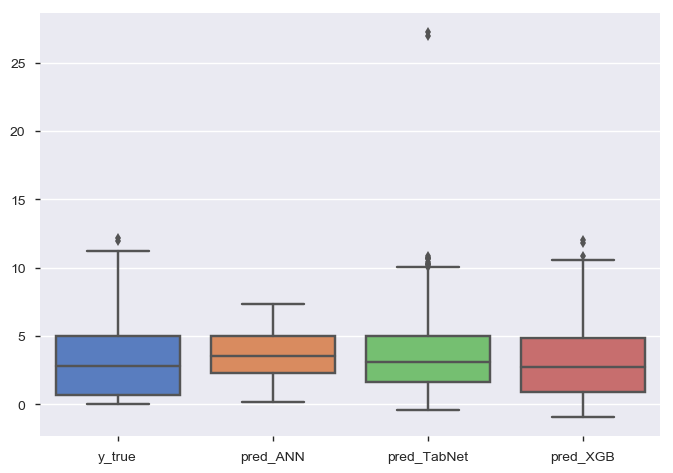

In [53]:
# Range of ground truth versus individual model predicted - BoxPlot
df_pred_test = pd.DataFrame(np.transpose([y_test.flatten(), y_pred_Ann_test.flatten(), y_pred_Tabnet_test.flatten(), y_pred_Xgb_test.flatten()]), columns=["y_true", "pred_ANN", "pred_TabNet", "pred_XGB"])
sns.boxplot(data= df_pred_test, palette="muted")

# Model Intepretations

In [61]:
#varimp_Ann = np.around(modelAnn.feature_importances_ , decimals=2)
varimp_Tabnet = np.around(modelTabnet.feature_importances_ , decimals=2)
varimp_Xgb = np.around(modelXgb.feature_importances_ , decimals=2)
#for feat, importance in zip(features, feature_importance):
#    print('{f}: {i}'.format(f=feat, i=importance))

In [ ]:
import shap
shap.initjs()
#y_pred_Ann_trainval
#y_trainval

def f(X):
    return modelAnn.predict(X).flatten()

#explainer = shap.KernelExplainer(f, X_trainval[:1000,:])
#shap_values = explainer.shap_values(X_trainval[1001:,:], nsamples=500)

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
#X_trainval_summary = shap.kmeans(X_trainval, 20)
explainer = shap.KernelExplainer(f, y_pred_Ann_trainval)
shap_values = explainer.shap_values(shap.sample(X_trainval,5000), nsamples=500) #use a random 5000 samples to 

shap.force_plot(explainer.expected_value, shap_values, features)

# Alternative implementations
# Not using kmean summary to approximate estimated values
# explainer = shap.KernelExplainer(f, shap.sample(X_trainval,50))

# In theory code below also works, but it runs extremely long
# explainer = shap.KernelExplainer(f, X_trainval)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


In [67]:
X_trainval.shape

(19224, 20)

In [69]:
X_trainval[:50,:].shape

(50, 20)

In [ ]:
print('Computing partial dependence plots...')

tic = time()

display = plot_partial_dependence(
    est, X_trainval, features, kind="both", subsample=50,
    n_jobs=3, grid_resolution=20, random_state=0
)

print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence on year, country, country-pair features'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

## Training Models - Exploration with LSTM (Failed)

In [ ]:
# convert data to 3-d array (sample_id, year, features) to work wth LSTM model
data_modelling_indexed = data_modelling.set_index(['year', 'pair_id'])

# Simple feature pre-processing
nunique = data_modelling_indexed.nunique()
types = data_modelling_indexed.dtypes

categorical_columns = []
categorical_dims =  {}

for col in data_modelling_indexed.columns[data_modelling_indexed.dtypes == object]:
    print(col, data_modelling_indexed[col].nunique())
    l_enc = LabelEncoder()
    data_modelling_indexed[col] = data_modelling_indexed[col].fillna("VV_likely")
    data_modelling_indexed[col] = l_enc.fit_transform(data_modelling_indexed[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)


features_3d = features.copy()
features_3d.remove('pair_id')
features_3d.remove('year')
print(features)
print(features_3d)

X_indexed = data_modelling_indexed[features_3d]
y_indexed = data_modelling_indexed[target]
print(X_indexed.shape)
print(y_indexed.shape)

X_3d = tf.convert_to_tensor(np.transpose(np.array(X_indexed.to_xarray().to_array()), (2,1,0)))
y_3d = tf.convert_to_tensor(np.transpose(np.array(y_indexed.to_xarray())[:,np.newaxis], (2,0,1)))


print(X_3d.shape)
print(y_3d.shape)

In [ ]:
# Define the lstm model
#
# @data              : a dataframe like the transformData return
# @l                 : loss function to build model
# @size_hidden_layer : size of the LSTM's hidden layer
# @dropout           : value of the model's dropout
# @returns           : the defined model

# data is perpared as a 3D array (samples, time steps, features)
# n_timeperiod = 10 for years 2004 until 2013; 2014 is reserved for testing so not counted
def defineLSTM(n_features = 18, n_timeperiod = 11, l = cpc_loss_keras, size_hidden_layer = 50, dropout = 0):
  n_features = n_features
  model = Sequential()
  if dropout > 0.0:
    model.add(Dropout(dropout, input_shape=(1,n_features)))
  model.add(LSTM(size_hidden_layer, activation='relu', input_shape=(n_timeperiod, n_features)))
  model.add(Dense(1))
  opt = keras.optimizers.Adam(learning_rate=0.01, clipnorm = 1)
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  model.compile(optimizer=opt, loss=l, metrics = custom_metrics_keras)

  return model

In [ ]:
modelLstm = defineLSTM()

history=modelLstm.fit(X_3d, y_3d, epochs=1000, batch_size=1280, verbose=1, validation_split=0.2)
#predictions = model.predict(X_test)
